In [1]:
from pathlib import Path
from typing import Dict

import mre
import numpy as np
import pandas as pd
import seaborn as sns

from tomato.audio.pitchdistribution import PitchDistribution

from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

%load_ext autoreload
%autoreload 2


## helper functions

We only need these once in the experiments, therefore there is no need to add them to `mre`.

In [2]:
def bhat(mtx1, mtx2):
    return -np.log(np.sum(np.sqrt(mtx1 * mtx2)))


In [3]:
def prepare_dataset(annotations, pcd_files, pcd_tags):
    NUM_BINS = int(1200 / float(pcd_tags["step_size"]))
    
    # prepare features
    X = np.zeros((len(annotations.data), NUM_BINS))
    mbids = np.array([])
    for ii, pf in enumerate(pcd_files):
        vals = PitchDistribution.from_json(pf).vals
        if len(vals) != NUM_BINS:
            raise ValueError(
                "%s has %d bins instead of %d."
                % (pf, len(vals), NUM_BINS)
            )
        X[ii, :] = PitchDistribution.from_json(pf).vals
        mbids = np.append(mbids, Path(pf).stem)

    y = annotations.data.set_index("mbid").loc[mbids].makam.values

    return mre.data.dataset.Dataset(X, y)


# Read data

## Annotations

In [4]:
annotations = mre.data.Annotation.from_mlflow()
display(annotations.head())

,dunya_uid,makam,mb_url,mbid,observations,tonic,verified
0,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,Acemasiran,http://musicbrainz.org/recording/00f1c6d9-c8ee...,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,,256.0,False
1,168f7c75-84fb-4316-99d7-acabadd3b2e6,Acemasiran,http://musicbrainz.org/recording/168f7c75-84fb...,168f7c75-84fb-4316-99d7-acabadd3b2e6,,115.2,False
2,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,Acemasiran,http://musicbrainz.org/recording/24f549dd-3fa4...,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,,232.5,False
3,407bb0b4-f19b-42ab-8c0a-9f1263126951,Acemasiran,http://musicbrainz.org/recording/407bb0b4-f19b...,407bb0b4-f19b-42ab-8c0a-9f1263126951,,233.5,False
4,443819eb-6092-420c-bd86-d946a0ad6555,Acemasiran,http://musicbrainz.org/recording/443819eb-6092...,443819eb-6092-420c-bd86-d946a0ad6555,,219.6,False


## Pitch Class Distributions

In [5]:
pcd_files = mre.data.PitchClassDistribution.from_mlflow()
pcd_tags = mre.data.PitchClassDistribution.get_tags()


# Prepare inputs

In [6]:
dataset = prepare_dataset(annotations, pcd_files, pcd_tags)
print(dataset)


Dataset with 1000 samples and 48 feature dimensions.


# Experimental Setup

In [7]:
ARCHITECTURES = [
    mre.experimentation.Architecture(  # from yesiler et al
        name="MultiLayerPerceptron",
        estimator=MLPClassifier(
            momentum=0.5,
            max_iter=10000,
            learning_rate="adaptive",
            learning_rate_init=0.001),
        param_grid={
            "hidden_layer_sizes": [50, 100],
            "alpha": [0.01, 0.001]
        }
    ),
    mre.experimentation.Architecture(  # from demirel et al
        name="SVM",
        estimator=SVC(kernel="rbf"),
        param_grid={
            "C": [10, 100, 1000],  # .001, .01, .1, 1 give worse results, omitted
            "gamma": [.1, 1, 10]  # .001, .01 give worse results, omitted
        }
    ),
    mre.experimentation.Architecture(  # from karakurt et al (morty)
        name="KNN",
        estimator=KNeighborsClassifier(),
        param_grid={
            "n_neighbors": [1, 3],
            "weights": ["distance"],  # "uniform" give worse results, omitted 
            "metric": [bhat, "manhattan"]  # "euclidean" gives worse results, omitted
        }
    ),
    mre.experimentation.Architecture(
        name="LogisticRegression",
        estimator=LogisticRegression(max_iter=100, solver="saga"),
        param_grid={
            "penalty": ["l2", 'l1'],
            "C": [0.1, 1, 10]
        }
    ),
#     mre.experimentation.Architecture(  # overfits heavily, omitted
#         name="RandomForest",
#         estimator=RandomForestClassifier(),
#         param_grid={
#             "n_estimators": [5, 10, 25, 50],
#             "criterion": ["gini", "entropy"],
#             "max_depth": [5, 10, 25, 50]
#         }
#     ),
#     mre.experimentation.Architecture(  # bad overall; commented
#         name="DecisionTree",
#         estimator=DecisionTreeClassifier(),
#         param_grid={
#             "criterion": ["gini", "entropy"],
#             "max_depth": [5, 10, 25, 50]
#         }
#     ),
]


## Nested 10 fold

In [8]:
nested_stratified_10_fold_cv_experiment = mre.experimentation.NestedStratified10FoldCV(
    num_splits=10, num_trials=10
)

nested_stratified_10_fold_cv_experiment.run(dataset, ARCHITECTURES)
nested_stratified_10_fold_cv_experiment.results.head()

Trial 0
   MultiLayerPerceptron, Test acc: 0.72∓0.04, Train acc: 0.89∓0.02, Max fit time: 1741.4 sec, Best Params: {'alpha': 0.001, 'hidden_layer_sizes': 100}
   SVM                 , Test acc: 0.72∓0.03, Train acc: 0.82∓0.01, Max fit time: 12.3 sec, Best Params: {'C': 10, 'gamma': 10}
   KNN                 , Test acc: 0.68∓0.05, Train acc: 0.89∓0.00, Max fit time: 182.6 sec, Best Params: {'metric': <function bhat at 0x7fcd809c10e0>, 'n_neighbors': 3, 'weights': 'distance'}
   LogisticRegression  , Test acc: 0.69∓0.04, Train acc: 0.74∓0.01, Max fit time: 46.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 1
   MultiLayerPerceptron, Test acc: 0.72∓0.03, Train acc: 0.87∓0.03, Max fit time: 1625.0 sec, Best Params: {'alpha': 0.001, 'hidden_layer_sizes': 100}
   SVM                 , Test acc: 0.72∓0.04, Train acc: 0.82∓0.01, Max fit time: 13.4 sec, Best Params: {'C': 10, 'gamma': 10}
   KNN                 , Test acc: 0.68∓0.03, Train acc: 0.89∓0.00, Max fit time: 182.1 sec, Best Par

,architecture,best_params_,cv_results_,fit_time,score_time,split_id,test_score,train_score,trial_id
0,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [240.78394026756285, 200.119...",1522.868211,0.007163,0,0.75,0.852222,0
1,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [244.10752544403076, 203.669...",1703.108196,0.011048,1,0.71,0.891111,0
2,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [232.59046065807343, 206.450...",1637.239339,0.013682,2,0.73,0.900000,0
3,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [257.0149509906769, 204.5143...",1741.354342,0.008712,3,0.64,0.917778,0
4,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [233.08519644737243, 198.554...",1577.472941,0.006910,4,0.68,0.888889,0


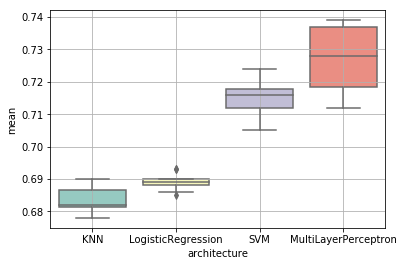

In [10]:
_ = nested_stratified_10_fold_cv_experiment.boxplot_best_models()

## 10 fold

In [11]:
stratified_10_fold_cv_experiment = mre.experimentation.Stratified10FoldCV(
    num_splits=10, num_trials=10
)

stratified_10_fold_cv_experiment.run(dataset, ARCHITECTURES)
stratified_10_fold_cv_experiment.results.head()

Trial 0
  MultiLayerPerceptron, Mean/std test acc : 0.72∓0.04, Mean/std train acc: 0.89∓0.01, Max fit time: 144.8 sec, Best Params: {'alpha': 0.001, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.72∓0.04, Mean/std train acc: 0.81∓0.00, Max fit time: 0.2 sec, Best Params: {'C': 1000, 'gamma': 0.1}
  KNN                 , Mean/std test acc : 0.68∓0.05, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.04, Mean/std train acc: 0.74∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 1
  MultiLayerPerceptron, Mean/std test acc : 0.72∓0.03, Mean/std train acc: 0.82∓0.01, Max fit time: 157.0 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.72∓0.03, Mean/std train acc: 0.82∓0.01, Max fit time: 0.2 sec, Best Params: {'C': 10, 'gamma': 10}
  KNN                 , Mean/std test acc : 0.68∓0.03, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.03, Mean/std train acc: 0.74∓0.00, Max fit time: 2.1 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 2
  MultiLayerPerceptron, Mean/std test acc : 0.73∓0.04, Mean/std train acc: 0.83∓0.02, Max fit time: 153.2 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.72∓0.03, Mean/std train acc: 0.82∓0.00, Max fit time: 0.2 sec, Best Params: {'C': 10, 'gamma': 10}
  KNN                 , Mean/std test acc : 0.68∓0.05, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.05, Mean/std train acc: 0.74∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 3
  MultiLayerPerceptron, Mean/std test acc : 0.74∓0.03, Mean/std train acc: 0.82∓0.01, Max fit time: 138.9 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.73∓0.04, Mean/std train acc: 0.82∓0.01, Max fit time: 0.2 sec, Best Params: {'C': 10, 'gamma': 10}
  KNN                 , Mean/std test acc : 0.69∓0.03, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.05, Mean/std train acc: 0.74∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 4
  MultiLayerPerceptron, Mean/std test acc : 0.73∓0.04, Mean/std train acc: 0.82∓0.01, Max fit time: 130.6 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.73∓0.02, Mean/std train acc: 0.82∓0.01, Max fit time: 0.2 sec, Best Params: {'C': 10, 'gamma': 10}
  KNN                 , Mean/std test acc : 0.69∓0.04, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.06, Mean/std train acc: 0.73∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 5
  MultiLayerPerceptron, Mean/std test acc : 0.72∓0.04, Mean/std train acc: 0.82∓0.01, Max fit time: 110.4 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.71∓0.03, Mean/std train acc: 0.82∓0.00, Max fit time: 0.2 sec, Best Params: {'C': 10, 'gamma': 10}
  KNN                 , Mean/std test acc : 0.68∓0.02, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.68∓0.03, Mean/std train acc: 0.74∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 6
  MultiLayerPerceptron, Mean/std test acc : 0.73∓0.03, Mean/std train acc: 0.82∓0.01, Max fit time: 140.4 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.73∓0.02, Mean/std train acc: 0.81∓0.01, Max fit time: 0.2 sec, Best Params: {'C': 1000, 'gamma': 0.1}
  KNN                 , Mean/std test acc : 0.68∓0.04, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.03, Mean/std train acc: 0.74∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 7
  MultiLayerPerceptron, Mean/std test acc : 0.72∓0.04, Mean/std train acc: 0.83∓0.02, Max fit time: 121.9 sec, Best Params: {'alpha': 0.001, 'hidden_layer_sizes': 50}
  SVM                 , Mean/std test acc : 0.73∓0.03, Mean/std train acc: 0.90∓0.00, Max fit time: 0.2 sec, Best Params: {'C': 100, 'gamma': 10}
  KNN                 , Mean/std test acc : 0.69∓0.04, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.03, Mean/std train acc: 0.74∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 8
  MultiLayerPerceptron, Mean/std test acc : 0.73∓0.04, Mean/std train acc: 0.82∓0.01, Max fit time: 118.6 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 100}
  SVM                 , Mean/std test acc : 0.72∓0.04, Mean/std train acc: 0.82∓0.01, Max fit time: 0.2 sec, Best Params: {'C': 10, 'gamma': 10}
  KNN                 , Mean/std test acc : 0.68∓0.05, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


  LogisticRegression  , Mean/std test acc : 0.69∓0.04, Mean/std train acc: 0.74∓0.01, Max fit time: 1.9 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 9
  MultiLayerPerceptron, Mean/std test acc : 0.73∓0.04, Mean/std train acc: 0.80∓0.01, Max fit time: 142.5 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 50}
  SVM                 , Mean/std test acc : 0.73∓0.04, Mean/std train acc: 0.81∓0.01, Max fit time: 0.2 sec, Best Params: {'C': 100, 'gamma': 1}
  KNN                 , Mean/std test acc : 0.69∓0.05, Mean/std train acc: 0.89∓0.00, Max fit time: 0.1 sec, Best Params: {'metric': <function bhat at 0x7fcd812014d0>, 'n_neighbors': 3, 'weights': 'distance'}
  LogisticRegression  , Mean/std test acc : 0.69∓0.04, Mean/std train acc: 0.74∓0.01, Max fit time: 2.0 sec, Best Params: {'C': 10, 'penalty': 'l1'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,architecture,best_params_,cv_results_,fit_time,score_time,split_id,test_score,train_score,trial_id
0,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [17.19892852306366, 24.22080...",144.83799,0.006953,0,0.78,0.888889,0
1,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [17.19892852306366, 24.22080...",144.83799,0.006953,1,0.75,0.898889,0
2,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [17.19892852306366, 24.22080...",144.83799,0.006953,2,0.68,0.883333,0
3,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [17.19892852306366, 24.22080...",144.83799,0.006953,3,0.64,0.910000,0
4,MultiLayerPerceptron,"{'alpha': 0.001, 'hidden_layer_sizes': 100}","{'mean_fit_time': [17.19892852306366, 24.22080...",144.83799,0.006953,4,0.70,0.867778,0


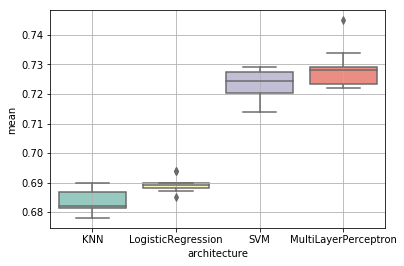

In [13]:
_ = stratified_10_fold_cv_experiment.boxplot_best_models()

## Shuffle CV with 10 splits

In [14]:
stratified_shuffle_cv_experiment = mre.experimentation.StratifiedShuffleCV(
    num_splits=10, num_trials=10
)

stratified_shuffle_cv_experiment.run(dataset, ARCHITECTURES)
stratified_shuffle_cv_experiment.results.head()

Trial 0
   MultiLayerPerceptron, Test acc: 0.72∓0.03, Train acc: 0.82∓0.02, Max fit time: 2530.0 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 50}
   SVM                 , Test acc: 0.72∓0.02, Train acc: 0.82∓0.01, Max fit time: 6.3 sec, Best Params: {'C': 10, 'gamma': 10}
   KNN                 , Test acc: 0.67∓0.03, Train acc: 0.89∓0.00, Max fit time: 427.8 sec, Best Params: {'metric': <function bhat at 0x7fcd7bade950>, 'n_neighbors': 3, 'weights': 'distance'}
   LogisticRegression  , Test acc: 0.62∓0.04, Train acc: 0.68∓0.01, Max fit time: 22.3 sec, Best Params: {'C': 10, 'penalty': 'l2'}
Trial 1
   MultiLayerPerceptron, Test acc: 0.71∓0.02, Train acc: 0.83∓0.02, Max fit time: 2728.5 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 50}
   SVM                 , Test acc: 0.71∓0.03, Train acc: 0.82∓0.01, Max fit time: 6.7 sec, Best Params: {'C': 10, 'gamma': 10}
   KNN                 , Test acc: 0.68∓0.03, Train acc: 0.89∓0.00, Max fit time: 422.0 sec, Best Params: {

,architecture,best_params_,cv_results_,fit_time,score_time,split_id,test_score,train_score,trial_id
0,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 100}","{'mean_fit_time': [280.765830540657, 330.52451...",2409.897316,0.002639,0,0.735,0.84625,0
1,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 50}","{'mean_fit_time': [290.91307566165926, 359.939...",2510.888942,0.001623,1,0.700,0.78500,0
2,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 50}","{'mean_fit_time': [296.96079099178314, 342.187...",2530.028131,0.001957,2,0.730,0.81125,0
3,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 100}","{'mean_fit_time': [259.22386636734007, 319.853...",2405.627091,0.004617,3,0.745,0.82250,0
4,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 50}","{'mean_fit_time': [285.17727732658386, 344.127...",2443.511315,0.002044,4,0.705,0.79750,0


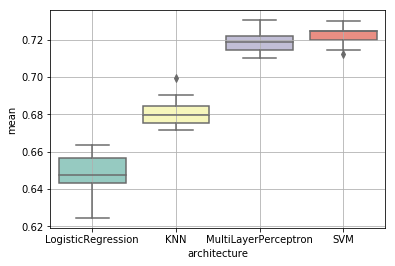

In [16]:
_ = stratified_shuffle_cv_experiment.boxplot_best_models()

In [ ]:
stratified_shuffle_cv_experiment.plot_confusion_matrix(architecture="SVM")

## Shuffled CV with single split

In [17]:
single_stratified_shuffle_cv_experiment = mre.experimentation.StratifiedShuffleCV(
    num_splits=1, num_trials=10
)

scores = single_stratified_shuffle_cv_experiment.run(dataset, ARCHITECTURES)
single_stratified_shuffle_cv_experiment.results.head()

Trial 0
   MultiLayerPerceptron, Test acc: 0.71∓0.02, Train acc: 0.82∓0.02, Max fit time: 2942.9 sec, Best Params: {'alpha': 0.01, 'hidden_layer_sizes': 50}
   SVM                 , Test acc: 0.72∓0.02, Train acc: 0.82∓0.01, Max fit time: 8.8 sec, Best Params: {'C': 10, 'gamma': 10}
   KNN                 , Test acc: 0.67∓0.03, Train acc: 0.89∓0.00, Max fit time: 419.0 sec, Best Params: {'metric': <function bhat at 0x7fcd7ba68ef0>, 'n_neighbors': 3, 'weights': 'distance'}
   LogisticRegression  , Test acc: 0.62∓0.04, Train acc: 0.69∓0.01, Max fit time: 18.6 sec, Best Params: {'C': 10, 'penalty': 'l2'}


,architecture,best_params_,cv_results_,fit_time,score_time,split_id,test_score,train_score,trial_id
0,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 100}","{'mean_fit_time': [287.61223142147065, 383.985...",2791.701989,0.003729,0,0.715,0.82625,0
1,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 50}","{'mean_fit_time': [317.9943726301193, 419.4593...",2942.875522,0.001600,1,0.705,0.81500,0
2,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 100}","{'mean_fit_time': [309.62239799499514, 403.585...",2862.673219,0.002984,2,0.715,0.84500,0
3,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 100}","{'mean_fit_time': [293.74264149665834, 384.274...",2790.289642,0.002573,3,0.735,0.83750,0
4,MultiLayerPerceptron,"{'alpha': 0.01, 'hidden_layer_sizes': 50}","{'mean_fit_time': [298.19014568328856, 390.056...",2805.909331,0.006360,4,0.725,0.80750,0


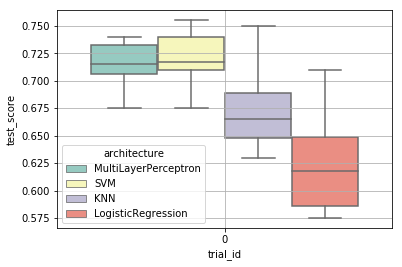

In [18]:
_ = single_stratified_shuffle_cv_experiment.boxplot_best_models_by_trial()

In [ ]:
stratified_shuffle_cv_experiment.plot_confusion_matrix(architecture="SVM")